## 客户分群：财务与信用行为画像 （K-Means）

用**客户财务与信用行为**特征，将借款人分成若干群体，例如：

- **低风险优质客户**：偿债能力强、信用记录好、违约率低
- **高负债高风险客户**：DTI 高、使用率高、历史逾期多
- **高收入高额度客户**：年收入高、借款金额大、利率相对可控
- **潜在违约客户**：逾期/破产记录多、查询多、违约率偏高

### 特征选择

| 类别 | 特征 | 含义 |
|------|------|------|
| 偿债能力 | annual_inc, dti, installment/annual_inc | 年收入、负债收入比、还款压力 |
| 信用历史 | delinq_2yrs, num_tl_90g_dpd_24m, pub_rec_bankruptcies, inq_last_6mths | 历史逾期、严重逾期笔数、破产记录、近期查询 |
| 信用使用 | revol_util | 循环使用率 |
| 信贷规模 | loan_amnt, int_rate, term | 金额、利率、期限 |
| 稳定性 | emp_length, home_ownership | 工作年限、房产状态（编码为数值）|

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings("ignore")
_candidates = ["PingFang SC", "Heiti SC", "SimHei", "Microsoft YaHei", "WenQuanYi Micro Hei", "Noto Sans CJK SC", "STHeiti", "Arial Unicode MS"]
_available = {f.name for f in fm.fontManager.ttflist}
_font = next((c for c in _candidates if c in _available), None)
if _font is None:
    for _f in _available:
        if any(x in _f for x in ("CJK", "Hei", "Song", "Ming", "Kai", "Fang", "SC", "TC")):
            _font = _f
            break
if _font:
    plt.rcParams["font.sans-serif"] = [_font]
plt.rcParams["axes.unicode_minus"] = False

DATA_DIR = Path("../data")
df = pd.read_csv(DATA_DIR / "loan_clean.csv", low_memory=False)

# 净收益、违约标记
df["net_profit"] = pd.to_numeric(df["total_pymnt"], errors="coerce") - pd.to_numeric(df["loan_amnt"], errors="coerce")
BAD_STATUS = ["Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)", "In Grace Period"]
df["is_default"] = df["loan_status"].isin(BAD_STATUS).astype(int)

# 数值化：利率、期限、还款压力、工作年限、房产
df["int_rate_num"] = pd.to_numeric(df["int_rate"].astype(str).str.replace("%", "", regex=False), errors="coerce")
if "term_months" not in df.columns and "term" in df.columns:
    df["term_months"] = pd.to_numeric(df["term"].astype(str).str.extract(r"(\d+)", expand=False), errors="coerce")
annual_inc = pd.to_numeric(df["annual_inc"], errors="coerce").replace(0, np.nan)
df["installment_inc_ratio"] = pd.to_numeric(df["installment"], errors="coerce") / annual_inc
df["installment_inc_ratio"] = df["installment_inc_ratio"].clip(upper=1).fillna(0)
# emp_length: "10+ years" -> 10, "5 years" -> 5
if "emp_length" in df.columns:
    el = df["emp_length"].astype(str).str.extract(r"(\d+)", expand=False)
    df["emp_length_num"] = pd.to_numeric(el, errors="coerce").fillna(0)
else:
    df["emp_length_num"] = 0
# home_ownership: 简单编码 MORTGAGE=2, OWN=1, RENT=0, OTHER=0
if "home_ownership" in df.columns:
    ho = df["home_ownership"].astype(str).str.upper()
    df["home_ownership_num"] = np.where(ho.str.contains("MORTGAGE"), 2, np.where(ho.str.contains("OWN"), 1, 0))
else:
    df["home_ownership_num"] = 0

# 其他数值列（可能带 % 或缺失）
for col in ["revol_util", "dti"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace("%", "", regex=False), errors="coerce")

# 推荐特征列表（只保留数据中存在的，共 8~12 个）
candidates = [
    "annual_inc", "dti", "installment_inc_ratio",
    "delinq_2yrs", "num_tl_90g_dpd_24m", "pub_rec_bankruptcies", "inq_last_6mths",
    "revol_util", "loan_amnt", "int_rate_num", "term_months",
    "emp_length_num", "home_ownership_num",
]
# pub_rec 作为 pub_rec_bankruptcies 的备选
if "pub_rec_bankruptcies" not in df.columns and "pub_rec" in df.columns:
    df["pub_rec_bankruptcies"] = pd.to_numeric(df["pub_rec"], errors="coerce")
feat_cols = [c for c in candidates if c in df.columns]
cl_df = df.dropna(subset=["net_profit"]).copy()
# 缺失特征填 0
for c in feat_cols:
    if c not in cl_df.columns:
        continue
    cl_df[c] = pd.to_numeric(cl_df[c], errors="coerce").fillna(0)
cl_df = cl_df.dropna(subset=feat_cols).copy()
X = cl_df[feat_cols].values
scaler = StandardScaler()
X_s = scaler.fit_transform(X)
print("聚类样本数:", len(cl_df), "| 特征数:", len(feat_cols), "| 特征:", feat_cols)

聚类样本数: 167981 | 特征数: 13 | 特征: ['annual_inc', 'dti', 'installment_inc_ratio', 'delinq_2yrs', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'inq_last_6mths', 'revol_util', 'loan_amnt', 'int_rate_num', 'term_months', 'emp_length_num', 'home_ownership_num']


**小结（数据与特征）**  
- 聚类样本：约 **16.8 万** 条（剔除净收益与特征缺失后），**13** 个数值特征。  
- 特征覆盖：偿债能力（年收入、DTI、还款收入比）、信用历史（逾期、严重逾期、破产、近期查询）、信用使用（revol_util）、信贷规模（金额、利率、期限）、稳定性（工作年限、房产编码）。  
- 已做标准化，为 K-Means 提供同量纲输入。

### KMeans 聚类（k=4 对应四类客户）

- 使用 **k=4** 将客户分为四类，对应业务上的四类画像：低风险优质、高收入高额度、高负债高风险、潜在违约。  
- 聚类在标准化后的特征空间上完成，便于后续按簇统计违约率与净收益。

In [2]:
# 四类客户：k=4
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cl_df["cluster"] = km.fit_predict(X_s)
print("聚类完成，k =", n_clusters)

聚类完成，k = 4


### 簇画像：特征、风险水平、授信策略

按簇统计特征均值、违约率、净收益，并打上业务标签（低风险优质 / 高负债高风险 / 高收入高额度 / 潜在违约），输出授信策略建议。

In [3]:
# 各簇统计：笔数、特征均值、违约率、平均净收益
agg_dict = {"cnt": ("net_profit", "count"), "avg_net_profit": ("net_profit", "mean"), "default_rate": ("is_default", "mean")}
for c in feat_cols:
    if c in cl_df.columns:
        agg_dict[f"avg_{c}"] = (c, "mean")
agg = cl_df.groupby("cluster").agg(**agg_dict).round(4)
if "avg_int_rate_num" in agg.columns:
    agg["avg_int_rate"] = agg["avg_int_rate_num"]
if "dti" in feat_cols and "avg_dti" not in agg.columns:
    agg["avg_dti"] = cl_df.groupby("cluster")["dti"].mean()

# 业务标签：四类客户（按规则分配）
# 潜在违约：违约率最高
# 高负债高风险：DTI 最高（排除已标潜在违约）
# 高收入高额度：年收入/金额最高（排除已标）
# 低风险优质：违约率最低、净收益相对较好
default_rate = agg["default_rate"]
dti_col = agg["avg_dti"] if "avg_dti" in agg.columns else agg.get("avg_dti", pd.Series(0, index=agg.index))
annual_col = agg.get("avg_annual_inc", agg.get("avg_loan_amnt", pd.Series(0, index=agg.index)))
labels = ["低风险优质客户", "高负债高风险客户", "高收入高额度客户", "潜在违约客户"]
cluster_to_label = {}
remaining = list(agg.index)
# 1) 潜在违约：default_rate 最高
c_bad = default_rate.loc[remaining].idxmax()
cluster_to_label[c_bad] = "潜在违约客户"
remaining.remove(c_bad)
# 2) 高负债高风险：剩余中 DTI 最高
if remaining:
    c_high_dti = dti_col.loc[remaining].idxmax()
    cluster_to_label[c_high_dti] = "高负债高风险客户"
    remaining.remove(c_high_dti)
# 3) 高收入高额度：剩余中 annual_inc 或 loan_amnt 最高
if remaining:
    c_high_inc = annual_col.loc[remaining].idxmax()
    cluster_to_label[c_high_inc] = "高收入高额度客户"
    remaining.remove(c_high_inc)
# 4) 低风险优质：最后剩余
for c in remaining:
    cluster_to_label[c] = "低风险优质客户"
agg["客户类型"] = agg.index.map(cluster_to_label)

# 风险水平（按违约率简化为 低/中/高）
agg["风险水平"] = agg["default_rate"].apply(lambda r: "高" if r >= 0.02 else ("中" if r >= 0.01 else "低"))

# 授信策略建议
def strategy(row):
    t = row["客户类型"]
    if "低风险优质" in t:
        return "可放宽额度与期限，优先投放，适度优惠利率"
    if "高负债高风险" in t:
        return "收紧额度或缩短期限，提高利率覆盖风险，加强贷后监控"
    if "高收入高额度" in t:
        return "可给较高额度与较长期限，利率适中，关注集中度"
    if "潜在违约" in t:
        return "从严准入，降低额度上限，高定价或拒绝，加强催收与核销准备"
    return "标准审批与定价"
agg["授信策略"] = agg.apply(strategy, axis=1)

# 最终输出：每类客户特征 + 风险水平 + 授信策略
out_cols = ["客户类型", "cnt", "default_rate", "风险水平", "avg_net_profit"]
if "avg_dti" in agg.columns:
    out_cols.insert(3, "avg_dti")
if "avg_int_rate" in agg.columns:
    out_cols.insert(3, "avg_int_rate")
out_cols += ["授信策略"]
result = agg[[c for c in out_cols if c in agg.columns]].copy()
result = result.rename(columns={"cnt": "笔数", "default_rate": "违约率", "avg_net_profit": "平均净收益", "avg_dti": "平均DTI", "avg_int_rate": "平均利率"})
display(result)
print("\n各簇特征摘要（部分）：")
display(agg[[c for c in agg.columns if c.startswith("avg_") and c not in ["avg_net_profit"]]].round(2).head())

,客户类型,笔数,违约率,平均利率,平均DTI,风险水平,平均净收益,授信策略
cluster,,,,,,,,
0,低风险优质客户,87334,0.0101,11.6807,18.2393,中,-9287.3114,可放宽额度与期限，优先投放，适度优惠利率
1,高收入高额度客户,2222,0.0135,15.3284,17.0502,中,-12471.9274,可给较高额度与较长期限，利率适中，关注集中度
2,高负债高风险客户,19211,0.0129,13.3884,19.0226,中,-12582.3233,收紧额度或缩短期限，提高利率覆盖风险，加强贷后监控
3,潜在违约客户,59214,0.0137,14.3251,21.3106,中,-21286.1101,从严准入，降低额度上限，高定价或拒绝，加强催收与核销准备



各簇特征摘要（部分）：


,avg_annual_inc,avg_dti,avg_installment_inc_ratio,avg_delinq_2yrs,avg_num_tl_90g_dpd_24m,avg_pub_rec_bankruptcies,avg_inq_last_6mths,avg_revol_util,avg_loan_amnt,avg_int_rate_num,avg_term_months,avg_emp_length_num,avg_home_ownership_num,avg_int_rate
cluster,,,,,,,,,,,,,,
0,74803.24,18.24,0.01,0.19,0.03,0.00,0.42,42.73,11125.94,11.68,36.14,5.61,0.94,11.68
1,96436.75,17.05,0.01,4.31,2.39,0.05,0.55,46.23,14722.70,15.33,42.64,6.16,1.22,15.33
2,77416.70,19.02,0.01,0.11,0.02,1.01,0.58,40.54,14832.98,13.39,43.88,6.33,1.14,13.39
3,100453.40,21.31,0.01,0.17,0.03,0.00,0.42,48.69,24526.39,14.33,54.96,6.41,1.31,14.33


- **低风险优质客户**（约 8.7 万笔）：违约率最低（约 1.01%），平均利率约 11.7%，平均净收益亏损约 0.93 万；建议放宽额度与期限、优先投放、适度优惠利率。  
- **高收入高额度客户**（约 0.2 万笔）：笔均金额与利率较高，违约率约 1.35%；建议给较高额度和期限、利率适中、关注集中度。  
- **高负债高风险客户**（约 1.9 万笔）：DTI 与破产记录等偏高；建议收紧额度/期限、提高定价、加强贷后监控。  
- **潜在违约客户**（约 5.9 万笔）：违约率最高（约 1.37%）、平均净收益亏损最大（约 2.1 万）；建议从严准入、降额度、高定价或拒绝、加强催收与核销准备。  


### 特征相关性 

- 相关性矩阵与热力图展示 13 个聚类特征之间的线性相关程度，用于检查多重共线性与特征冗余。  
- 若某两个特征高度相关，可考虑只保留其一或做业务取舍，避免聚类被重复信息主导；特征选择时已考虑业务含义与稳定性，相关性用于验证


                       annual_inc       dti  installment_inc_ratio  \
annual_inc               1.000000 -0.119477              -0.140516   
dti                     -0.119477  1.000000               0.568702   
installment_inc_ratio   -0.140516  0.568702               1.000000   
delinq_2yrs              0.040078 -0.024826              -0.032660   
num_tl_90g_dpd_24m       0.007841 -0.020799              -0.015572   
pub_rec_bankruptcies    -0.021540 -0.008598              -0.010552   
inq_last_6mths           0.034109  0.005492              -0.040335   
revol_util               0.056768  0.130730               0.027163   
loan_amnt                0.225739  0.066399               0.303113   
int_rate_num            -0.054736  0.136995               0.090370   
term_months              0.037010  0.059710               0.049427   
emp_length_num           0.060023  0.035832              -0.037392   
home_ownership_num       0.126528  0.061149              -0.035744   

                   

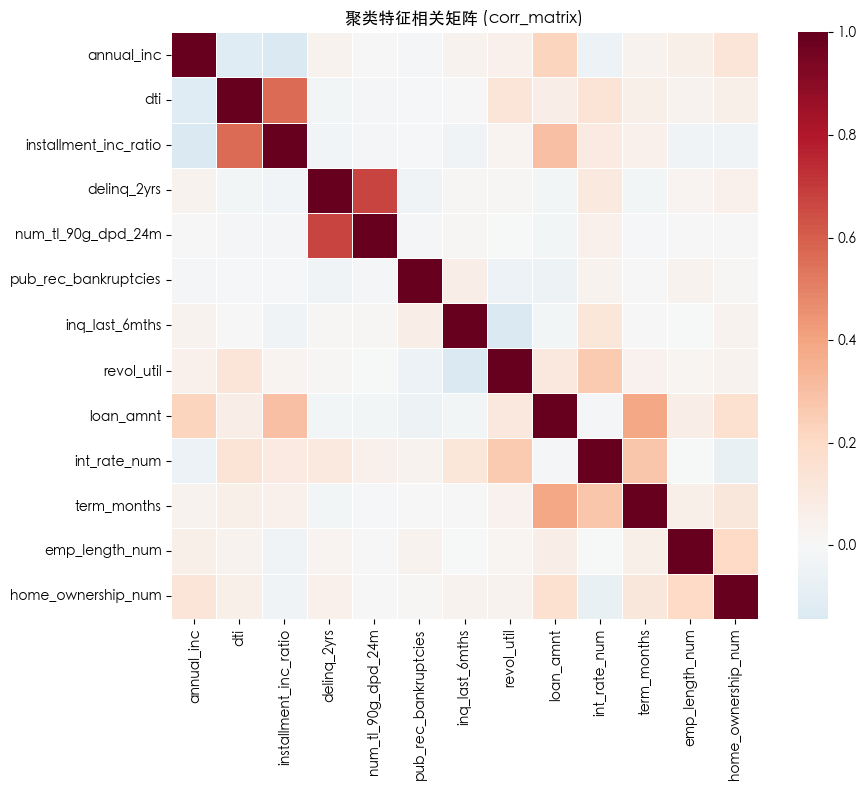

In [4]:
import seaborn as sns

# 1) 相关矩阵：聚类特征之间的相关性
corr = cl_df[feat_cols].corr()
print(corr)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="RdBu_r", center=0, square=True, linewidths=0.5, ax=ax)
ax.set_title("聚类特征相关矩阵 (corr_matrix)")
plt.tight_layout()
plt.show()


**相关矩阵分析**
- 矩阵显示“偿债压力”（dti / installment_inc_ratio）和“逾期严重程度”（delinq_2yrs / num_tl_90g_dpd_24m）各有一对强相关，可考虑降冗余；
- 其余关系符合风险定价与客户资质逻辑，特征整体可支撑聚类与违约分析。

### 可视化：按簇看利率与净收益

- 散点图按簇着色：横轴利率、纵轴净收益，可直观看到不同簇在「定价–收益」平面上的分布。  
- 高利率不一定对应高净收益（违约导致亏损），潜在违约客户簇往往在高利率、低/负净收益区域；低风险优质客户多集中在利率较低、亏损相对较小的区域。  
- 支撑「按风险定价、对高风险客群提价或收紧」的结论。

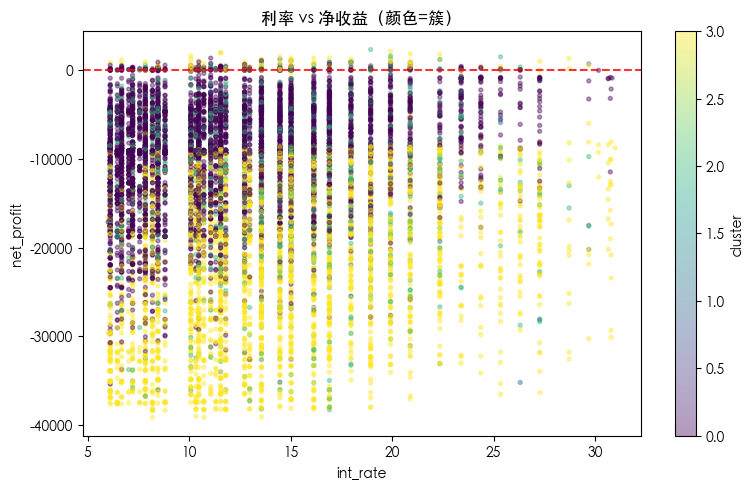

In [5]:
# 抽样绘图（数据量大时）
n_plot = min(10000, len(cl_df))
idx = np.random.RandomState(42).choice(len(cl_df), n_plot, replace=False)
plot_df = cl_df.iloc[idx]
int_rate_num = plot_df["int_rate_num"] if "int_rate_num" in plot_df.columns else pd.to_numeric(plot_df["int_rate"].astype(str).str.replace("%", "", regex=False), errors="coerce")

fig, ax = plt.subplots(figsize=(8, 5))
sc = ax.scatter(int_rate_num, plot_df["net_profit"], c=plot_df["cluster"], cmap="viridis", alpha=0.4, s=8)
ax.axhline(0, color="red", linestyle="--", alpha=0.8)
ax.set_xlabel("int_rate")
ax.set_ylabel("net_profit")
ax.set_title("利率 vs 净收益（颜色=簇）")
plt.colorbar(sc, label="cluster")
plt.tight_layout()
plt.show()

### 可选：PCA 二维投影看簇分布

- 将 13 维特征用 PCA 降至 2 维并绘图，按簇着色，用于观察四类客户在二维空间中的分离情况。  
- 若簇之间有一定分离、重叠不多，说明 K-Means 得到的群组在特征空间上有区分度；若有明显重叠，可结合业务解释（如部分客群本身特征相近）或尝试不同 k。  


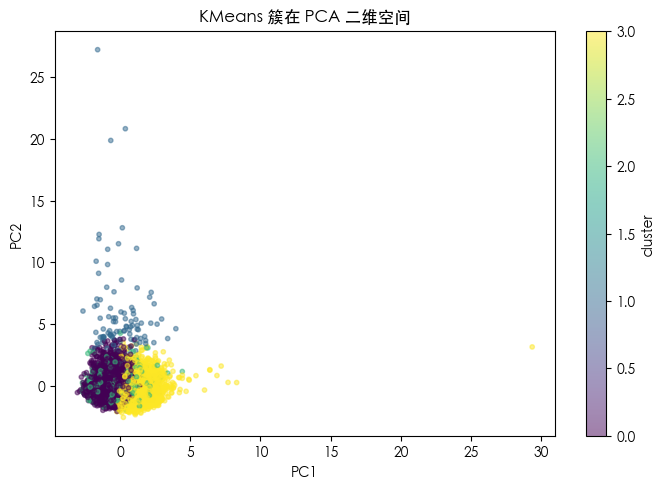

In [6]:
n_plot = min(8000, len(X_s))
idx = np.random.RandomState(42).choice(len(X_s), n_plot, replace=False)
X_plot = X_s[idx]
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_plot)
labels_plot = cl_df["cluster"].iloc[idx]

plt.figure(figsize=(7, 5))
plt.scatter(X2[:, 0], X2[:, 1], c=labels_plot, cmap="viridis", alpha=0.5, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans 簇在 PCA 二维空间")
plt.colorbar(label="cluster")
plt.tight_layout()
plt.show()